# Image classification with 'image_dataset_from_directory' method

# Creating train/val/test datasets using split-folders package

The split-folders package allow us to create 3 folders of train/val/test images

The input folder should have the following format (Gregoire's function output):

input/

    class1/
        img1.jpg
        img2.jpg
        ...
    class2/
        imgWhatever.jpg
        ...
    ...
    
    
And we get this

output/

    train/
        class1/
            img1.jpg
            ...
        class2/
            imga.jpg
            ...
            
    val/
    
        class1/
        
            img2.jpg
            ...
        class2/
            imgb.jpg
            ...
    test/
        class1/
            img3.jpg
            ...
        class2/
            imgc.jpg
            ...

In [1]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

assert TRAIN_RATIO + VAL_RATIO + TEST_RATIO == 1
assert TRAIN_RATIO != 0
assert VAL_RATIO != 0
assert TEST_RATIO != 0

In [2]:
import splitfolders
!rm -rf "/home/jupyter/wikiart/train_val_test_True_1440"
splitfolders.ratio("/home/jupyter/wikiart/wikiart-movement-genre_True-class_8-merge_mov-1-n_1440_max", 
                   output="/home/jupyter/wikiart/train_val_test_True_1440",
                   seed=1337, ratio=(TRAIN_RATIO, VAL_RATIO, TEST_RATIO), 
                   group_prefix=None);

Copying files: 11520 files [00:20, 573.46 files/s]


# Deep learning workflow

## Imports

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, models, applications

# Note : we are using TensorFlow Core v2.5.0, in TensorFlow Core v2.6.0 all the data augmentaation layers are part of tf.keras.layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Rescaling
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax

## Global variables

In [69]:
USERNAME = 'pablo'
MODEL = 'Custom'

MAIN_PATH = '/home/jupyter/' 
DATASETS_FOLDER = 'wikiart/train_val_test_True_1440/'

TRAIN_DIR = MAIN_PATH + DATASETS_FOLDER + 'train'
VAL_DIR = MAIN_PATH + DATASETS_FOLDER + 'val'
TEST_DIR = MAIN_PATH + DATASETS_FOLDER + 'test'

In [70]:
BATCH_SIZE = 128
EPOCHS = 1000
IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 8

## Datasets setup

### Train dataset

In [71]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TRAIN_DIR,
    labels='inferred',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True)

assert len(train_ds.class_names) == NUM_CLASSES

Found 9216 files belonging to 8 classes.


### Validation dataset

In [72]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=VAL_DIR,
    labels='inferred',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical',
    batch_size=BATCH_SIZE)

assert len(val_ds.class_names) == NUM_CLASSES

Found 1152 files belonging to 8 classes.


### Test dataset

In [73]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=TEST_DIR,
    labels='inferred',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    label_mode='categorical',
    batch_size=BATCH_SIZE)

assert len(test_ds.class_names) == NUM_CLASSES

Found 1155 files belonging to 8 classes.


In [76]:
class_names = train_ds.class_names
class_names

['abstract',
 'color_field_painting',
 'cubism',
 'expressionism',
 'impressionism',
 'realism',
 'renaissance',
 'romanticism']

In [9]:
total_images_count = (int(len(list(train_ds)))+int(len(list(val_ds)))+int(len(list(test_ds))))*BATCH_SIZE
# total_images_count = 33011 + 4123 + 4134
total_images_count

11520

## Dataset optimization for performance

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(int(total_images_count/10)).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model : custom

### Data augmentation layers

In [11]:
data_augmentation_layers = models.Sequential([
    RandomFlip("horizontal", input_shape=(224, 224,3)),
    RandomRotation(0.3),
    RandomZoom(0.3)])

### Model setup

In [12]:
model = Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),
    Rescaling(1./255),
    data_augmentation_layers,
    layers.Conv2D(8, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
    
])

# Batch normalization


In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)       

### Callbacks

#### EarlyStopping

In [14]:
es = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

#### ReduceLROnPlateau

In [15]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-8)

#### ModelCheckpoint

In [16]:
checkpoint_dir = f"{MAIN_PATH}logs/{USERNAME}/{MODEL}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
mcp = ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_freq=10,
    save_best_only=True)

In [17]:
%load_ext tensorboard
# !rm -rf ./logs/ResNet50
recorded_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"{MAIN_PATH}logs/{USERNAME}/{MODEL}/" + \
    recorded_time + \
    f"-images_{total_images_count}" + \
    f"-batch_{BATCH_SIZE}"
tsboard = TensorBoard(log_dir=log_dir) # voir https public

### Model compilation

In [18]:
model.compile(optimizer=Adamax(learning_rate=0.01), 
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

### Model fitting

In [19]:
history = model.fit(
    train_ds, 
    epochs=EPOCHS, 
    validation_data=val_ds, 
    callbacks=[es, rlrp, tsboard])

model.save(f"{MAIN_PATH}models/{USERNAME}/{MODEL}/" + \
    recorded_time + \
    f"-images_{total_images_count}" + \
    f"-batch_{BATCH_SIZE}")

Epoch 1/1000
72/72 [==============================] - 39s 126ms/step - loss: 2.1305 - accuracy: 0.1424 - val_loss: 2.0227 - val_accuracy: 0.1675
Epoch 2/1000
72/72 [==============================] - 6s 87ms/step - loss: 1.9835 - accuracy: 0.1841 - val_loss: 2.0828 - val_accuracy: 0.1684
Epoch 3/1000
72/72 [==============================] - 6s 87ms/step - loss: 1.9579 - accuracy: 0.2030 - val_loss: 2.0236 - val_accuracy: 0.1918
Epoch 4/1000
72/72 [==============================] - 6s 87ms/step - loss: 1.9327 - accuracy: 0.2158 - val_loss: 1.9529 - val_accuracy: 0.2300
Epoch 5/1000
72/72 [==============================] - 6s 87ms/step - loss: 1.9099 - accuracy: 0.2250 - val_loss: 1.8861 - val_accuracy: 0.2491
Epoch 6/1000
72/72 [==============================] - 6s 88ms/step - loss: 1.8804 - accuracy: 0.2428 - val_loss: 1.8614 - val_accuracy: 0.2630
Epoch 7/1000
72/72 [==============================] - 6s 88ms/step - loss: 1.8438 - accuracy: 0.2663 - val_loss: 1.7349 - val_accuracy: 0.32

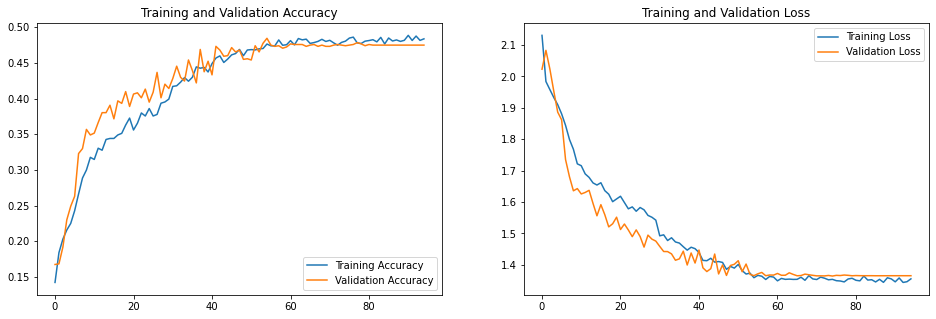

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
fig.savefig(f"/home/jupyter/figures/{USERNAME}/{MODEL}/{recorded_time}-images_{total_images_count}-batch_{BATCH_SIZE}", dpi=300)

In [24]:
model.evaluate(test_ds, callbacks=tsboard)

9/9 [==============================] - 3s 42ms/step - loss: 1.3544 - accuracy: 0.4714


[1.3544485569000244, 0.4713541567325592]

## Test prediction 

In [26]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [30]:
layer_outputs = [layer.output for layer in model.layers[2:]]
layer_outputs

[<KerasTensor: shape=(None, 224, 224, 8) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 112, 112, 8) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 112, 112, 16) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 56, 56, 16) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 56, 56, 32) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 28, 28, 32) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 28, 28, 64) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 14, 14, 64) dtype=float32 (created by layer 'max_pooling2d_3')>,
 <KerasTensor: shape=(None, 14, 14, 64) dtype=float32 (created by layer 'dropout')>,
 <KerasTensor: shape=(None, 14, 14, 128) dtype=float32 (created by layer 'conv2d_4')>,
 <KerasTensor: shape=(None, 25088) dtype=float32 (created by layer 'flatten')>,
 <KerasTensor: shape=(None, 2508

In [35]:
visualize_model = tf.keras.models.Model(model.input, layer_outputs)
visualize_model

In [36]:
!pwd

/home/jupyter/notebooks/movement


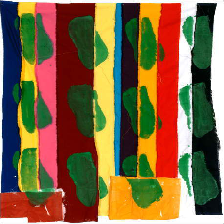

In [40]:
img = load_img('/home/jupyter/image_pred/color-field-painting_claude-viallat_unknown-title-3.jpg', target_size=(224, 224))
img

In [62]:
x = img_to_array(img)
x = x.reshape((1, 224, 224, 3))
x.shape
x = x/255

(1, 224, 224, 3)

In [64]:
pred = model.predict(x)

In [116]:
print(f"1. {class_names[np.argsort(np.max(pred, axis=0))[-1]]} ':' {round(pred[0][np.argsort(np.max(pred, axis=0))[-1]]*100, 2)}%")
print(f"2. {class_names[np.argsort(np.max(pred, axis=0))[-2]]} ':' {round(pred[0][np.argsort(np.max(pred, axis=0))[-2]]*100, 2)}%")
print(f"3. {class_names[np.argsort(np.max(pred, axis=0))[-3]]} ':' {round(pred[0][np.argsort(np.max(pred, axis=0))[-3]]*100, 2)}%")

1. color_field_painting ':' 79.67%
2. romanticism ':' 9.34%
3. abstract ':' 8.87%
